In [1]:
%pip install -U opencv-python
%pip install -U matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np;
import cv2 as cv;
import os
from os.path import join as joinPath


In [3]:
from matplotlib import pyplot as plt

## Helper to show image on VSCode. Because cv.imshow doesn't work there.
def showImage(title: str, image: cv.Mat, color: bool = True):
    if (color):
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(title)
    plt.show()


In [4]:
def otsuThreshold(image: cv.Mat):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    return cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

In [5]:
bedsheetImage = cv.imread('samples/Bedsheet_image.jpg')
karcheepImage = cv.imread('samples/Karcheep.jpg')
lightClothImage = cv.imread('samples/Lightweight_Cloth.jpg')
shirtFabricImage = cv.imread('samples/Shirt_fabric.jpg')
towelImage = cv.imread('samples/Towel fabric.jpg')

allImages = [bedsheetImage, karcheepImage, lightClothImage, shirtFabricImage, towelImage]

In [6]:
## Not sure what it does but opencv tutorial does this
## https://docs.opencv.org/4.x/d2/dbd/tutorial_distance_transform.html
def blackBackground(image: cv.Mat) -> cv.Mat:
    src = image.copy()
    src[np.all(src == 255, axis=2)]
    return src


In [7]:
## Does laplacian filtering (without applying above blackBackground)
def laplacianSharpening(image: cv.Mat, coefficient: int = 1) -> cv.Mat:
    kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32) * coefficient
    imgLaplacian = cv.filter2D(image, cv.CV_32F, kernel)
    sharp = np.float32(image)
    imgResult = sharp - imgLaplacian
    imgResult = np.clip(imgResult, 0, 255)
    imgResult = imgResult.astype('uint8')
    return imgResult

In [8]:
## Helper to avoid nesting too many parentheses
def pipeline(image: cv.Mat, functions):
    for transform in functions:
        image = transform(image)
    return image

In [9]:
## Distance transform a grayscale image
def distanceTransform(image: cv.Mat, distanceType=cv.DIST_L2, maskSize=3):
    return cv.distanceTransform(image, distanceType, maskSize)

In [10]:
def binaryThreshold(image: cv.Mat) -> cv.Mat:
    return cv.threshold(image, 100, 255, cv.THRESH_BINARY)[1]

In [66]:
def preprocess(image: cv.Mat) -> cv.Mat:
    return pipeline(image, [
        lambda image: laplacianSharpening(image, 2),
        otsuThreshold,
        distanceTransform,
        ])

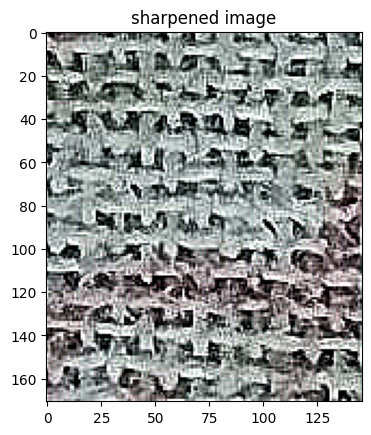

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


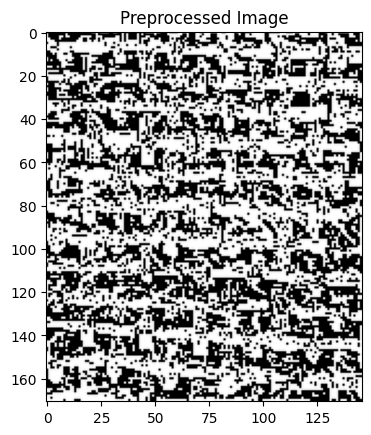

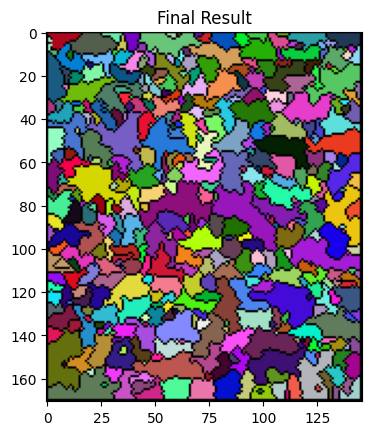

In [67]:
import random as rng

image = cv.imread('samples/Lightweight_Cloth_11x11.jpg')
imagePre = preprocess(image)
imagePre8u = imagePre.astype(np.uint8)
contours, _ = cv.findContours(imagePre8u, cv.RETR_LIST, cv.CHAIN_APPROX_TC89_KCOS)
markers = np.zeros(imagePre.shape, dtype=np.int32)

for i in range(len(contours)):
    cv.drawContours(markers, contours, i, i+1, -1)
cv.circle(markers, (5,5), 3, (255,255,255), -1)
markers_8u = (markers * 10).astype('uint8')

cv.watershed(laplacianSharpening(image), markers)
mark = markers.astype('uint8')
mark = cv.bitwise_not(mark)
# uncomment this if you want to see how the mark
# image looks like at that point
# cv.imshow('Markers_v2', mark)
# Generate random colors
colors = []
for contour in contours:
    colors.append((rng.randint(0,256), rng.randint(0,256), rng.randint(0,256)))
# Create the result image
dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)
# Fill labeled objects with random colors
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        index = markers[i,j]
        if index > 0 and index <= len(contours):
            dst[i,j,:] = colors[index-1]
# Visualize the final image
showImage('sharpened image', laplacianSharpening(image))
showImage('Preprocessed Image', imagePre)
showImage('Final Result', dst)


In [68]:
len(contours)

514